<a href="https://www.bigdatauniversity.com"><img src = "https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width = 400, align ="center"></a>

<h1 align=center><font size = 5> SVM (Support Vector Machines)</font></h1>

En este ejercicio, utilizarás Máquinas de Soporte Vectorial (SVM) (Support Vector Machines) para construir y entrenar un modelo utilizando registros de células humanas para luego clasificarlas en benignas o malignas.

SVM trabaja enlazando datos con un dimensión espacial de forma tal que los puntos de datos sean categorizados, inclusive cuando los datos no son linealmente separables. Un separador entre categorías primero se encuentra, luego los datos se transorman para que el separador pueda dibujarse como un hiperplane. Luego, rasgos de nuevos datos se pueden utilizar para predecir el grupo al cual un nuevo registro debería pertencer.

In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt

###  Cargar datos de Cancer 
El ejemplo se basa en un conjunto de datos que están disponibles al público en el Repositorio de Machine Learning de la UCI [Asuncion y Newman, 2007](http://mlearn.ics.uci.edu/MLRepository.html). El conjunto de datos consiste de varios registros de células humanas, cada una, conteniendo los valores de un conjunto de características de células. Los campos en cada registro son:

|Field name|Description|
|--- |--- |
|ID|Clump thickness|
|Clump|Clump thickness|
|UnifSize|Uniformity of cell size|
|UnifShape|Uniformity of cell shape|
|MargAdh|Marginal adhesion|
|SingEpiSize|Single epithelial cell size|
|BareNuc|Bare nuclei|
|BlandChrom|Bland chromatin|
|NormNucl|Normal nucleoli|
|Mit|Mitoses|
|Class|Benign or malignant|

Para los propósitos de este ejemplo, utilizamos un conjunto de datos que tiene un pequeño número de predictores en cada registro. Para descargar los datos, utilizaremos !wget` para descargarlo de IBM Object Storage.  
__¿Sabías?__ Cuando se trata de Machine Learning, seguro trabajarás con grandes datasets (juego de datos). Entonces, ¿dónde podrás guardar esos datos? IBM ofrece una oportunidad única para las empresas, con 10 Tb de IBM Cloud Object Storage: [Regístrese ahora gratuitamente](http://cocl.us/ML0101EN-IBM-Offer-CC)

In [2]:
#Hacer click aquí y presionar Shift+Enter
!wget -O cell_samples.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/cell_samples.csv

--2021-12-07 12:33:03--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/cell_samples.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20675 (20K) [text/csv]
Saving to: ‘cell_samples.csv’

cell_samples.csv    100%[===================>]  20.19K  --.-KB/s    in 0.001s  

2021-12-07 12:33:03 (31.3 MB/s) - ‘cell_samples.csv’ saved [20675/20675]



### Cargar los Datos a partir de un archivo CSV  

In [3]:
cell_df = pd.read_csv("cell_samples.csv")
cell_df.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


El archivo ID contiene los identificadores del paciente. Las características de las muestras de las células de cada paciente están contenidas en los campos Clump to Mit. Los valores van del 1 al 10, siendo 1 el más cerca a benigno.

El campo Class contiene el diagnóstico, como se confirmó por procedimientos médicos separados, si son las muestras benignas o no (valor = 2) o maligno (valor = 4).

Miremos a la distribución de las clases basadas en el grosor y uniformidad del tamaña de la célula:

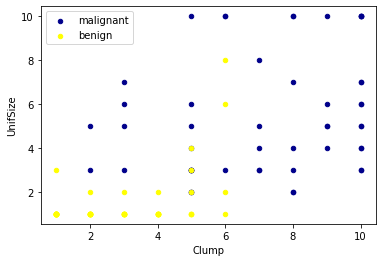

In [4]:
ax = cell_df[cell_df['Class'] == 4][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='DarkBlue', label='malignant');
cell_df[cell_df['Class'] == 2][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='Yellow', label='benign', ax=ax);
plt.show()

## Preprocesamiento de Datos y selección

Miremos primero al tipo de dato de las columnas:

In [5]:
cell_df.dtypes

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

Parece que la columna __BareNuc__ incluye algunos valores que no son numéricos. Podemos eliminar esas filas:

In [6]:
cell_df = cell_df[pd.to_numeric(cell_df['BareNuc'], errors='coerce').notnull()]
cell_df['BareNuc'] = cell_df['BareNuc'].astype('int')
cell_df.dtypes

ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int64
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

In [7]:
feature_df = cell_df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]
X = np.asarray(feature_df)
X[0:5]

array([[ 5,  1,  1,  1,  2,  1,  3,  1,  1],
       [ 5,  4,  4,  5,  7, 10,  3,  2,  1],
       [ 3,  1,  1,  1,  2,  2,  3,  1,  1],
       [ 6,  8,  8,  1,  3,  4,  3,  7,  1],
       [ 4,  1,  1,  3,  2,  1,  3,  1,  1]])

Queremos que el modelo prediga el valor de la columna Class (si es benigno (=2), si es maligno (=4)). Como este campo puede tener uno de dos valores posibles, necesitaremos cambiar su nivel de medición para reflejar eso.

In [8]:
cell_df['Class'] = cell_df['Class'].astype('int')
y = np.asarray(cell_df['Class'])
y [0:5]

array([2, 2, 2, 2, 2])

## Train/Test dataset

Ahora, dividimos el set de datos en entrenamiento y prueba:

In [9]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (546, 9) (546,)
Test set: (137, 9) (137,)


# Modelado (SVM con aprendizaje Scikit)

El algoritmo SVM ofrece elegir funciones para realizar su procesamiento. Básicamente, mapear los datos en un espacio dimensional más alto se llama kernelling. La función matemática utilizada para la transformación se conoce como la función kernel, y puede ser de distintos tipos, a ser:

    1.Lineal
    2.Polimonial
    3.Función de base Radial (RBF)
    4.Sigmoide
Cada una de estas funciones tiene sus características, pros y contras y su ecuación, pero como no hay una forma sencilla de saber la función que mejor funcionaría, elegimos utilizar diferentes funciones y comparar los resultados. Utilicemos la función por omisión, RBF (Función Basada en Radio) para este lab.

In [19]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Luego que el modelo cuadró, se puede utilizar para predecir nuevos valores:

In [20]:
yhat = clf.predict(X_test)
yhat [0:5]

array([2, 4, 2, 4, 2])

## Evaluación

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Esta función imprime y marca la matriz de confusión.
    Se puede aplicar Normalización seteando la variable `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Matriz de confusión, sin normalización')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta True')
    plt.xlabel('Etiqueta predecida')

              precision    recall  f1-score   support

           2       1.00      0.94      0.97        90
           4       0.90      1.00      0.95        47

   micro avg       0.96      0.96      0.96       137
   macro avg       0.95      0.97      0.96       137
weighted avg       0.97      0.96      0.96       137

Matriz de confusión, sin normalización
[[85  5]
 [ 0 47]]


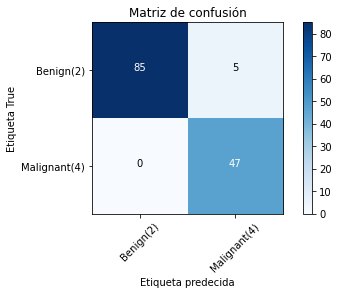

In [23]:
# Computar la matriz de confusión
cnf_matrix = confusion_matrix(y_test, yhat, labels=[2,4])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Benign(2)','Malignant(4)'],normalize= False,  title='Matriz de confusión')

Se puede utilizar facilmente el __f1_score__ de la librería sklearn:

In [24]:
from sklearn.metrics import f1_score
kernel_rbf_score = f1_score(y_test, yhat, average='weighted')
kernel_rbf_score

0.9639038982104676

Intentemos el índice jaccard para dar precisión:

In [16]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat)

0.9635036496350365

## Práctica
¿Se puede reconstruir el modelo, pero esta vez con un kernel __linear__? Podría utilizar la opción __kernel='linear'__, cuando defina el SVM. ¿Cómo cambia la exactitud con la nueva función kernel?

In [26]:
# Escribe tu código aquí
clf2 = svm.SVC(kernel='linear')
clf2.fit(X_train, y_train)

yhat2 = clf2.predict(X_test)
kernel_linear_score = f1_score(y_test, yhat, average='weighted')

print("Avg F1-score: %.4f" % f1_score(y_test, yhat2, average='weighted'))
print("Jaccard score: %.4f" % jaccard_similarity_score(y_test, yhat2))
print(f"linear: {kernel_linear_score} - rbf: {kernel_rbf_score} = {kernel_linear_score - kernel_rbf_score}")


Avg F1-score: 0.9639
Jaccard score: 0.9635
linear: 0.9639038982104676 - rbf: 0.9639038982104676 = 0.0


Double-click __aquí__ para la solución.

<!-- Tu respuesta está debajo:
    
clf2 = svm.SVC(kernel='linear')
clf2.fit(X_train, y_train) 
yhat2 = clf2.predict(X_test)
print("Avg F1-score: %.4f" % f1_score(y_test, yhat2, average='weighted'))
print("Jaccard score: %.4f" % jaccard_similarity_score(y_test, yhat2))

-->

## ¿Deseas aprender más?

IBM SPSS Modeler es una plataforma para analytics que contiene varios algoritmos de machine learning. Fue diseñada para acercar inteligencia predictiva a las decisiones hechas por individuos, grupos, sistemas, toda la empresa. Un free trial está disponible a través de este curso en: [SPSS Modeler](http://cocl.us/ML0101EN-SPSSModeler).

Asi mismo, puedes utilizar Watson Studio para ejecutar estos notebooks más rápido y con datasets más grandes. Watson Studio es una solución en la nube lider de IBM's para científicos de datos, construída por científicos de datos. Con Jupyter notebooks, RStudio, Apache Spark y librerías conocidas pre instaladas en la nube, Watson Studio posibilita a los científicos de datos colaborar en sus proyectos sin tener que instalar nada. Sumate a la comunidad de usuarios Watson Studio hoy mismo por medio de una cuenta gratuita en [Watson Studio](https://cocl.us/ML0101EN_DSX)

### ¡Gracias por completar esta lección!

Notebook creado por: <a href = "https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>

<hr>
Copyright &copy; 2018 [Cognitive Class](https://cocl.us/DX0108EN_CC). Este lab y su código fuente fueron registrados bajo los términos de [MIT License](https://bigdatauniversity.com/mit-license/).​